
## Section 1: Problem Formulation

### Introduction:
In this project, we aim to explore the effectiveness of contrastive learning, specifically using the SimCLR algorithm, 
for image classification tasks under the constraint of having limited labeled data. Contrastive learning is a technique 
in self-supervised learning that learns to encode similar items closer in the feature space while pushing dissimilar items further apart.


In [1]:
import sys
on_linux = sys.platform.startswith('linux')

In [2]:
# Import necessary libraries
import torch

# Check if CUDA is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
args = {
    "dataset": "cifar10",
    "model": "resnet50",
    "batch_size": 256,
    "sample_rate": 1,
    "epochs": 10,
    "n_views": 2,
    "out_dim": 128,
    "lr": 1e-3,
    "wd": 1e-6,
    "log_every_n_steps": 5,
    "n_workers": 16,
    "temperature": 0.07,
    "learning": "contrastive",
    "val_split": 0.2,
    "ft_ratio": 0.1,
}


## Section 2: Dataset Preparations

In this section, we will prepare the CIFAR-10, CIFAR-100, and MedMNIST datasets for training. 
We will apply necessary transformations and split the datasets into training, validation, and test sets.


In [4]:
from dataset import SimCLRDataset
data = SimCLRDataset(args["dataset"])
build_dataloader = lambda dataset: torch.utils.data.DataLoader(
    dataset,
    batch_size=args["batch_size"],
    shuffle=True,
    drop_last=True,
    num_workers=args["n_workers"],
)
train_dataset, val_dataset = data.get_train_val_datasets(args["n_views"], args["val_split"])
train_loader = build_dataloader(train_dataset)
val_loader = build_dataloader(val_dataset)
test_dataset = data.get_test_dataset(args["n_views"])
test_loader = build_dataloader(test_dataset)
num_classes = data.num_classes
print("# Classes:", num_classes)
print("# Train, Val, Test:", len(train_dataset), len(val_dataset), len(test_dataset))

Files already downloaded and verified
Files already downloaded and verified
# Classes: 10
# Train, Val, Test: 40000 10000 10000


In [10]:
ft_dataset = torch.utils.data.Subset(
                train_dataset, range(int(len(train_dataset) * args["ft_ratio"]))
            )


## Section 3: Deep Learning Model

In this section, we will prepare the popular choice of deep learning model like ResNet18 and VGG16.


In [22]:
from model import SimCLRCNN 
model_args = {
    "backbone": args["model"],
    "out_dim": args["out_dim"] if args["learning"] == "contrastive" else num_classes,
    "mod": args["learning"] == "contrastive",
}
model = SimCLRCNN(**model_args).to(device)
if on_linux:
    model = torch.compile(model)
    torch.set_float32_matmul_precision('high')

## Section 4: Contrastive Training

In [23]:
from train import contrastive_training, supervised_training
from eval import info_nce_loss
if args["learning"] == "contrastive":
    loss_fn = info_nce_loss
    criterion = torch.nn.CrossEntropyLoss()
    train_records, test_records = contrastive_training(model, train_loader, val_loader, loss_fn, criterion, device, args)
else:
    loss_fn = torch.nn.CrossEntropyLoss()
    train_records, test_records = supervised_training(model, train_loader, val_loader, loss_fn, device, args)

100%|██████████| 156/156 [00:36<00:00,  4.28it/s]

Epoch: 0	Loss: 5.9275	


Epoch: 0	Top1 accuracy: 0.8013	Top5 accuracy: 3.7560	Test loss: 5.9547


100%|██████████| 156/156 [00:12<00:00, 12.78it/s]


Epoch: 1	Loss: 5.8712	


100%|██████████| 156/156 [00:11<00:00, 13.03it/s]


Epoch: 2	Loss: 5.6687	


100%|██████████| 156/156 [00:11<00:00, 13.02it/s]


Epoch: 3	Loss: 5.6108	


100%|██████████| 156/156 [00:11<00:00, 13.04it/s]


Epoch: 4	Loss: 5.5523	


100%|██████████| 156/156 [00:12<00:00, 12.88it/s]

Epoch: 5	Loss: 5.4812	


Epoch: 5	Top1 accuracy: 3.5206	Top5 accuracy: 11.7889	Test loss: 5.5497


100%|██████████| 156/156 [00:12<00:00, 12.77it/s]


Epoch: 6	Loss: 5.5614	


100%|██████████| 156/156 [00:12<00:00, 12.74it/s]


Epoch: 7	Loss: 5.3367	


100%|██████████| 156/156 [00:12<00:00, 12.80it/s]


Epoch: 8	Loss: 5.4351	


100%|██████████| 156/156 [00:12<00:00, 12.31it/s]


Epoch: 9	Loss: 5.0615	


100%|██████████| 156/156 [00:13<00:00, 11.61it/s]

Epoch: 10	Loss: 5.2881	


Epoch: 10	Top1 accuracy: 5.1332	Top5 accuracy: 15.6500	Test loss: 5.3502


100%|██████████| 156/156 [00:13<00:00, 11.42it/s]


Epoch: 11	Loss: 5.1902	


100%|██████████| 156/156 [00:13<00:00, 11.66it/s]


Epoch: 12	Loss: 4.9923	


100%|██████████| 156/156 [00:13<00:00, 11.19it/s]


Epoch: 13	Loss: 4.8384	


100%|██████████| 156/156 [00:13<00:00, 11.37it/s]


Epoch: 14	Loss: 4.9436	


100%|██████████| 156/156 [00:13<00:00, 11.44it/s]

Epoch: 15	Loss: 4.7542	


Epoch: 15	Top1 accuracy: 9.8107	Top5 accuracy: 24.9199	Test loss: 4.8907


100%|██████████| 156/156 [00:13<00:00, 11.86it/s]


Epoch: 16	Loss: 4.8020	


100%|██████████| 156/156 [00:14<00:00, 10.49it/s]


Epoch: 17	Loss: 4.9277	


100%|██████████| 156/156 [00:14<00:00, 10.54it/s]


Epoch: 18	Loss: 4.8642	


100%|██████████| 156/156 [00:13<00:00, 11.47it/s]


Epoch: 19	Loss: 4.6530	


100%|██████████| 156/156 [00:13<00:00, 11.15it/s]

Epoch: 20	Loss: 4.7753	


Epoch: 20	Top1 accuracy: 9.8708	Top5 accuracy: 25.3506	Test loss: 4.8803


100%|██████████| 156/156 [00:13<00:00, 11.25it/s]


Epoch: 21	Loss: 4.6145	


100%|██████████| 156/156 [00:13<00:00, 11.20it/s]


Epoch: 22	Loss: 4.6531	


100%|██████████| 156/156 [00:13<00:00, 11.64it/s]


Epoch: 23	Loss: 4.5088	


100%|██████████| 156/156 [00:13<00:00, 11.47it/s]


Epoch: 24	Loss: 4.5807	


100%|██████████| 156/156 [00:13<00:00, 11.35it/s]

Epoch: 25	Loss: 4.3523	


Epoch: 25	Top1 accuracy: 15.1893	Top5 accuracy: 34.0194	Test loss: 4.4744


100%|██████████| 156/156 [00:14<00:00, 10.98it/s]


Epoch: 26	Loss: 4.5763	


100%|██████████| 156/156 [00:13<00:00, 11.30it/s]


Epoch: 27	Loss: 4.4485	


100%|██████████| 156/156 [00:14<00:00, 10.59it/s]


Epoch: 28	Loss: 4.1999	


100%|██████████| 156/156 [00:14<00:00, 10.41it/s]


Epoch: 29	Loss: 4.2595	


100%|██████████| 156/156 [00:14<00:00, 10.99it/s]

Epoch: 30	Loss: 4.1533	


Epoch: 30	Top1 accuracy: 17.1575	Top5 accuracy: 36.4083	Test loss: 4.4185


100%|██████████| 156/156 [00:13<00:00, 11.36it/s]


Epoch: 31	Loss: 4.4476	


100%|██████████| 156/156 [00:15<00:00, 10.20it/s]


Epoch: 32	Loss: 4.0159	


100%|██████████| 156/156 [00:15<00:00, 10.25it/s]


Epoch: 33	Loss: 4.1609	


100%|██████████| 156/156 [00:14<00:00, 10.56it/s]


Epoch: 34	Loss: 4.3453	


100%|██████████| 156/156 [00:14<00:00, 10.94it/s]

Epoch: 35	Loss: 4.0845	


Epoch: 35	Top1 accuracy: 20.4577	Top5 accuracy: 41.1358	Test loss: 4.1071


100%|██████████| 156/156 [00:14<00:00, 10.90it/s]


Epoch: 36	Loss: 4.3385	


100%|██████████| 156/156 [00:14<00:00, 10.90it/s]


Epoch: 37	Loss: 4.1436	


100%|██████████| 156/156 [00:14<00:00, 10.79it/s]


Epoch: 38	Loss: 4.2146	


100%|██████████| 156/156 [00:13<00:00, 11.41it/s]


Epoch: 39	Loss: 4.2166	


100%|██████████| 156/156 [00:15<00:00, 10.34it/s]

Epoch: 40	Loss: 4.0440	


KeyboardInterrupt: 

In [ ]:
import pandas as pd
timestamp = pd.Timestamp.now().strftime("%m%d%H%M")

df = pd.DataFrame.from_records(train_records)
test_df = pd.DataFrame.from_records(test_records)
df.to_csv(f"logs/{args['model']}_{args['dataset']}_{timestamp}_train.csv", index=False)
test_df.to_csv(f"logs/{args['model']}_{args['dataset']}_{timestamp}_test.csv", index=False)
display(test_df)

,loss,top1,top5
0,6.008001,0.846354,3.540665
1,5.407154,4.557292,14.322917
2,5.133770,8.248197,21.624599
3,4.735356,14.608373,30.794271
4,4.411285,19.731571,38.196114
5,4.095326,24.984976,44.275841
6,3.924604,28.140024,47.115385
7,3.740223,31.129808,50.235377
8,3.602589,31.830929,52.033253
9,3.370684,36.929087,56.575521


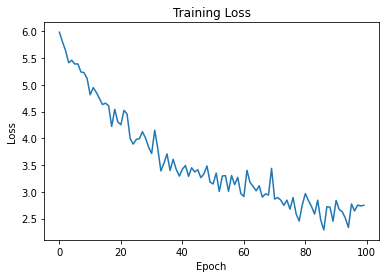

In [ ]:
import matplotlib.pyplot as plt
plt.plot(df['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

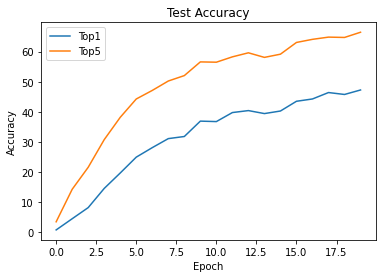

In [ ]:
plt.plot(test_df['top1'])
plt.plot(test_df['top5'])
plt.legend(['Top1', 'Top5'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Test Accuracy')
plt.show()


In [27]:
import pickle
(pickle.load(open("/home/levscaut/ece1508/tune_res.pkl", "rb")).best_trial.config)

{'dataset': 'cifar10',
 'model': 'resnet50',
 'batch_size': 256,
 'sample_rate': 1,
 'epochs': 1,
 'n_views': 2,
 'out_dim': 256,
 'lr': 0.0008745773868479316,
 'wd': 1e-06,
 'log_every_n_steps': 5,
 'n_workers': 16,
 'temperature': 0.07,
 'learning': 'contrastive',
 'val_split': 0.2}